<a href="https://colab.research.google.com/github/RazvanGolan/Faculty-3rd-year/blob/main/pi/test2/pi_test2_ex4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# exercise 4

import torch
import torchvision
from torch import nn
from matplotlib import pyplot as plt
from IPython import display
import warnings
import os
import requests
import zipfile
import tarfile
import torchvision
from torchvision import transforms

In [ ]:
X = torch.normal(0.0, 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

In [ ]:
def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    plt.rcParams['figure.figsize'] = figsize

In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((24, 24)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])

In [ ]:
trainset = torchvision.datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = transforms
)

In [ ]:
batch_size = 64
data_iter = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [ ]:
net_G = nn.Sequential(nn.Linear(2, 2))

In [ ]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=1, **kwargs):
        super(D_block, self).__init__(**kwargs)

        self.first_conv = nn.Conv2d(1, out_channels, kernel_size=1)
        self.activation = nn.ReLU()

        self.last = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.batch = nn.BatchNorm2d(out_channels)

        self.left = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1)
        self.middle = nn.Conv2d(out_channels, out_channels, kernel_size=2, stride=2)
        self.right = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2)

    def forward(self, X):
        print(X.shape)
        first = self.first_conv(X)
        first = self.activation(first)

        out = torch.split(first, 3)

        left = self.left(out)
        right = self.right(out)
        middle = self.middle(out)
        middle = self.activation(middle)

        out = torch.cat((left, middle, right), dim=1)

        out = self.last(out)
        out = self.batch(out)

        return out

In [ ]:
net_D = nn.Sequential(
    D_block(96),
    D_block(96),
    D_block(96),
    nn.Conv2d(96, 1, kernel_size=1)
   )

In [ ]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +
              loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

In [ ]:
def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G

In [ ]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    D_loss = 0
    G_loss = 0
    total_examples = 0
    for epoch in range(num_epochs):
        # Train one epoch
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            D_loss += update_D(X, Z, net_D, net_G, loss, trainer_D)
            G_loss += update_G(Z, net_D, net_G, loss, trainer_G)
            total_examples += batch_size
        # Visualize generated examples
        Z = torch.normal(0, 1, size=(100, latent_dim))
        fake_X = net_G(Z).detach().numpy()
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])
        # Show the losses
        loss_D, loss_G = D_loss/total_examples, G_loss/total_examples
        animator.add(epoch + 1, (loss_D.cpu().detach().numpy(), loss_G.cpu().detach().numpy()))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, ')

torch.Size([64, 1, 24, 24])


TypeError: conv2d() received an invalid combination of arguments - got (tuple, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!tuple of (Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor)!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!tuple of (Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Ten

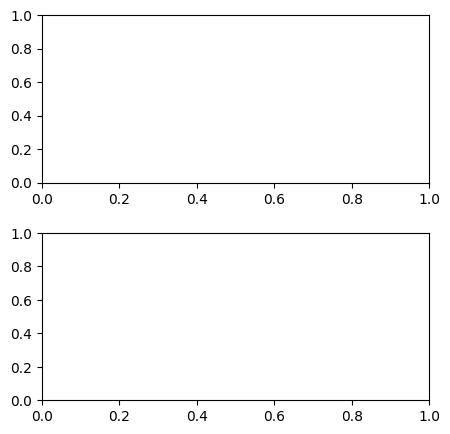

In [ ]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.05, 90, 1
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G,
      latent_dim, data[:100].detach().numpy())